# Python Group
## Lab Two: Exploring Image Data
### Wali Chaudhary, Bryce Shurts, & Alex Wright

## 1. Business Understanding

# TODO

### Citation & Acknowledgement
The Hotels Reservation dataset is liscenced under the [GNU General Public License, version 2](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html) and was provided by Preet Viradiya on [Kaggle](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset).

## 2. Data Preperation

In [1]:
# Handle all imports for notebook

# Generic list pulled from last project, modify as desired
import pandas as pd
from pandas import ( DataFrame, Series )
import numpy as np
from numpy import ndarray
import os
from os import listdir
from os.path import isfile, join
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
import random
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim

In [2]:
df: DataFrame = pd.read_csv("metadata.csv")

In [3]:
df.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


Immediately we can see that we have an unnamed title with a set of IDs, which can be safely removed

In [4]:
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


It looks like the images are not particularly uniform in composition. Let's investigate further.

Resolutions by count:
 (512, 512, 3)    884
(225, 225, 3)    364
(630, 630, 3)    126
(256, 256, 3)    105
(236, 236, 3)     89
(251, 201, 3)     80
(217, 232, 3)     53
(168, 300, 3)     52
(221, 228, 3)     51
(198, 150, 3)     45
(252, 200, 3)     44
(417, 428, 3)     43
(222, 227, 3)     40
(201, 173, 3)     38
(244, 206, 3)     38
(442, 442, 3)     34
(192, 192, 3)     32
(250, 201, 3)     31
(231, 218, 3)     31
(234, 215, 3)     28
Name: shape, dtype: int64


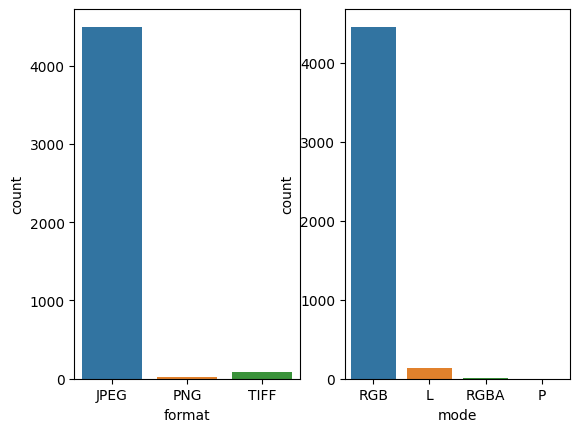

In [5]:
fig, ax = plt.subplots(1,2)
sns.countplot(x="format", data=df, ax=ax[0])
sns.countplot(x="mode", data=df, ax=ax[1])
print("Resolutions by count:\n", df["shape"].value_counts()[0:20])
# Way too many resolutions to plot...
#sns.countplot(x="shape", data=df, ax=ax[2])
plt.show()

We can see that we have a few different images that are not in the JPEG format and/or are not using the RGB color mode, which are both the most common. Since conversions would be computationally expensive and lossy, and since the number of images that are in the wrong format is relatively few, they will be dropped.
Resolutions will also be restricted to the largest square images in the top 20 most frequent resolutions, with all images to be downscaled to the smallest image to avoid losing data in trying to upscale (shown to be worse than downscaling by [this article](https://medium.com/neuronio/how-to-deal-with-image-resizing-in-deep-learning-e5177fad7d89).

In [6]:
# First we identify undesirable images
bad_columns = df[(df["format"] != "JPEG") | (df["mode"] != "RGB") |
                 ((df["shape"] != "(630, 630, 3)")
                  & (df["shape"] != "(512, 512, 3)")
                  & (df["shape"] != "(442, 442, 3)")
                  & (df["shape"] != "(256, 256, 3)")
                  & (df["shape"] != "(236, 236, 3)")
                  & (df["shape"] != "(225, 225, 3)")
                  & (df["shape"] != "(192, 192, 3)"))]
df.drop(bad_columns.index, inplace=True)
bad_columns = bad_columns["image"] # For later deletion

In [7]:
# Then we remove images we don't want to convert or otherwise process
# We could import the images first and then delete from the numpy arrays to preserve the github dataset, but that's a lot of wasted time & space.
files = [file for file in listdir("Brain Tumor Data Set/Brain Tumor/") if isfile(join("Brain Tumor Data Set/Brain Tumor/", file))] + [file for file in listdir("Brain Tumor Data Set/Healthy/") if isfile(join("Brain Tumor Data Set/Healthy/", file))]
bad_files = [file for file in files if file in bad_columns.tolist()]
for file in bad_files:
    if "Not" in file:
        os.remove(join("Brain Tumor Data Set/Healthy/", file))
    else:
        os.remove(join("Brain Tumor Data Set/Brain Tumor/", file))

In [8]:
# Confirm we still have more than 1000 images
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 4585
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1548 non-null   object
 1   class   1548 non-null   object
 2   format  1548 non-null   object
 3   mode    1548 non-null   object
 4   shape   1548 non-null   object
dtypes: object(5)
memory usage: 72.6+ KB


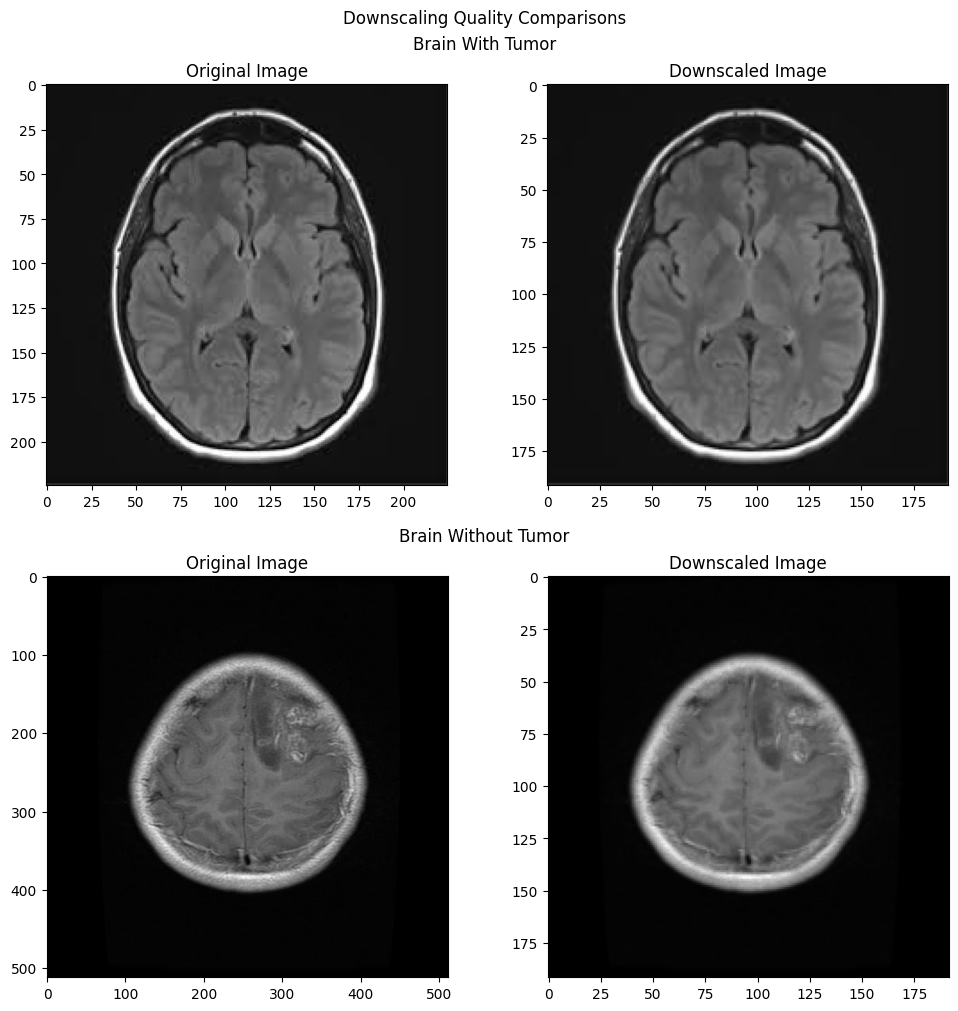

In [9]:
from skimage.color import rgb2gray

# Now import each image as a numpy array & do the final conversion of their resolutions
# Thoughts on what to do with resolutions? I say convert all to the smallest dimension (225x225)
cancer_images = []
healthy_images = []
original_images = [file for file in listdir("Brain Tumor Data Set/Brain Tumor/") if isfile(join("Brain Tumor Data Set/Brain Tumor/", file))] + [file for file in listdir("Brain Tumor Data Set/Healthy/") if isfile(join("Brain Tumor Data Set/Healthy/", file))]
for image in original_images:
    if "Not" in image:
        cancer_images.append(plt.imread(join("Brain Tumor Data Set/Healthy/", image)))
    else:
        healthy_images.append(plt.imread(join("Brain Tumor Data Set/Brain Tumor/", image)))

images = []
for image_set in (cancer_images, healthy_images): 
    for image in image_set:
        # Apply the resizing non-uniformly since evidently it affects images
        # even if they're the the same size as the target resolution.
        # Difference with Lienar PCA was:
        #   Applied to every image:
        #     233 components with λ > 1 for 92% explanation
        #   Applied to mis-sized images:
        #     256 components with λ > 1 for 99% explanation
        
        #images.append(resize(image, (192, 192), anti_aliasing=True).flatten())
        if len(image) != 192:
            images.append(rgb2gray(resize(image, (192, 192), anti_aliasing=True)).flatten())
        else:
            images.append(rgb2gray(image).flatten())
images = np.array(images)

fig = plt.figure(constrained_layout=True, figsize=(10,10))
fig.suptitle("Downscaling Quality Comparisons")
subfigs = fig.subfigures(2, 1)
ax_cancer = subfigs[0].subplots(1, 2)
subfigs[0].suptitle("Brain With Tumor")
ax_cancer[0].imshow(cancer_images[0], cmap='gray')
ax_cancer[0].set_title("Original Image")
ax_cancer[1].imshow(images[0].reshape(192, 192), cmap='gray')
ax_cancer[1].set_title("Downscaled Image")
ax_healthy = subfigs[1].subplots(1, 2)
subfigs[1].suptitle("Brain Without Tumor")
ax_healthy[0].imshow(healthy_images[0], cmap='gray')
ax_healthy[0].set_title("Original Image")
ax_healthy[1].imshow(images[len(cancer_images)].reshape(192, 192), cmap='gray')
ax_healthy[1].set_title("Downscaled Image")
plt.show()

## 3. Data Reduction

### 3.1 PCA Preperations
Typically, we would need to do some extra preprocessing of our data to ensure that everything it set within the same range of values, which PCA is highly sensitive to. However, since we have already bound all of our images to the same color mode (RGB), we know that every pixel will be, essentially, a triplet of uint8 repersentations for color between 0 & 255, which will work perfectly well with PCA.

With this taken care of and our data already flattened into rows of samples (images) with columns of features (pixels), our data is ready is be fit to a set of PCAs: both linear and randomized will be used and comparisons drawn between their effectiveness.

### 3.2 Linear PCA
The linear PCA is relatively straightfoward, using a full SVD solver with 128 potential components. Originally this was set to 1% of the total pixels per image, but after a good component threshold was found it was decreased to a nearby power of 2 to make the graph below easier to view.

What constitutes this "good threshold"? We set this as the point at which the eigenvalue (λ) assocaited with a component reaches 1, which is commonly known as the *Kaiser rule*: it is at this point that it is no more significant than simply having a single variable (i.e., a single color channel for a pixel) with regard to explaining the varience of the image. Therefore, anything above an *λ > 1* is kept, as it is beneifical for explaining varience when compared to simply keeping an extra feature in the dataset.

Once we fit the first linear PCA and find this theshold, we can run a new linear PCA that only targets the *N* components found to be useful, creating a new transformation that we can begin analyzing.

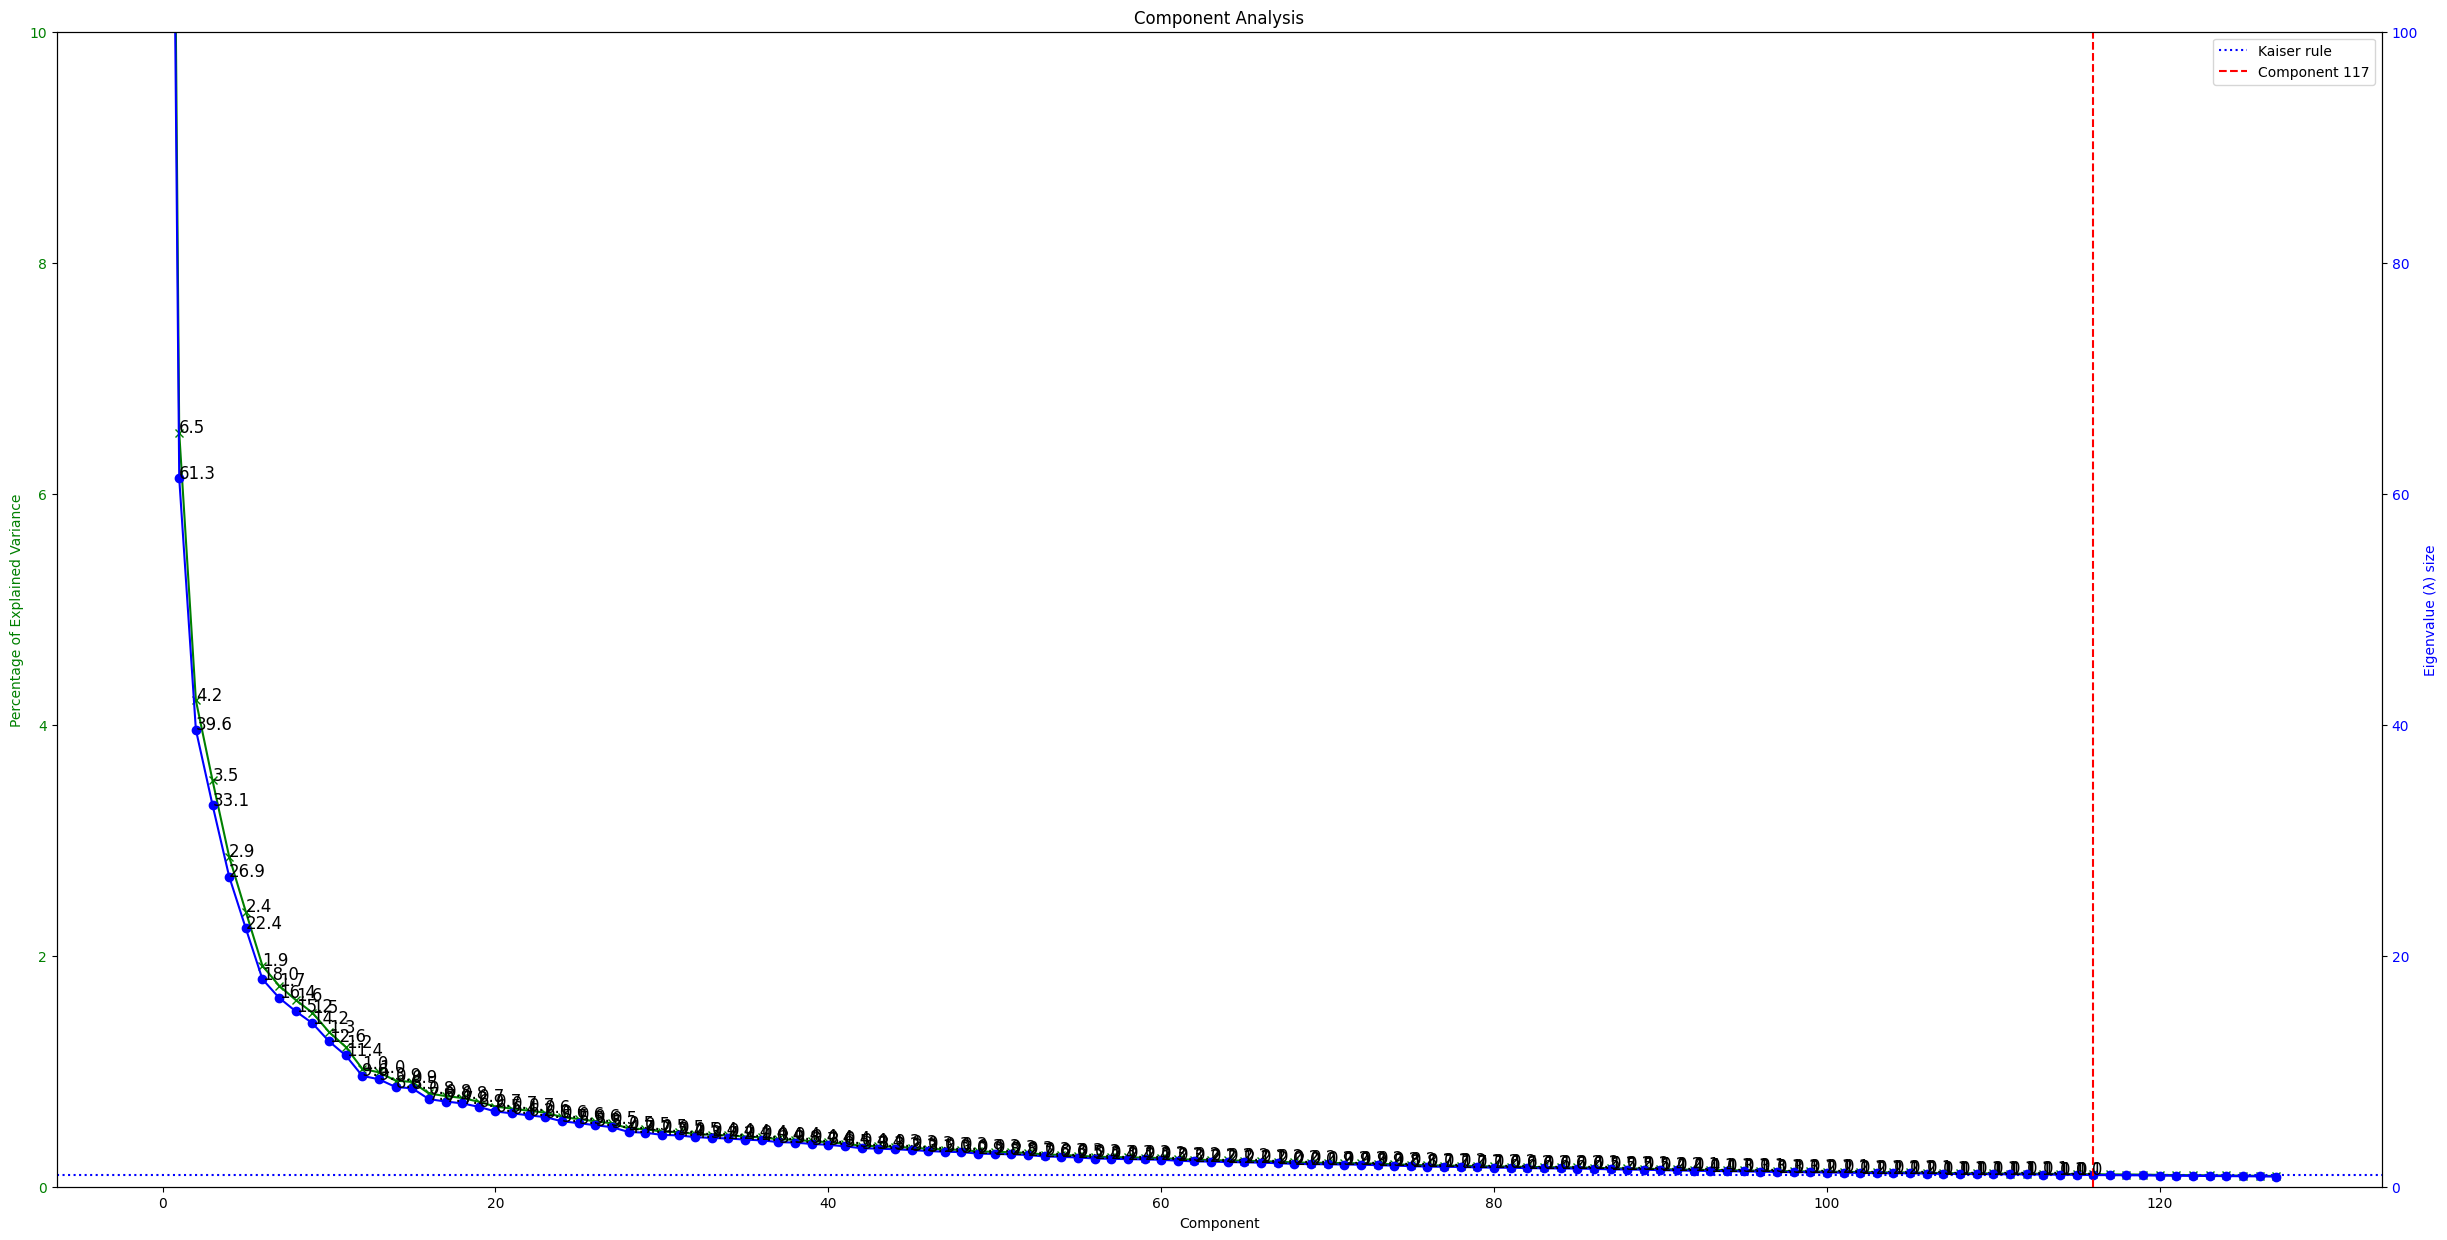

Amount of variance explained by 116 components s.t. λ_component > 1: 84.79999999999998%


In [123]:
# Linear PCA
pca = PCA(n_components=128, svd_solver="full")
pca_results = pca.fit_transform(images)

color_var = "#008000"
color_eig = "#0000FF"
cutoff = 1
ylim = 10
fig, ax_var = plt.subplots(figsize=(30,15))
ax_eig = ax_var.twinx()
ax_var.set_xlabel("Component")
ax_var.set_title("Component Analysis")
ax_var.set_ylim(0, ylim)
ax_eig.set_ylim(0, ylim * 10)

ax_var.plot(pca.explained_variance_ratio_ * 100, marker="x", color=color_var)
ax_var.set_ylabel('Percentage of Explained Variance', color=color_var)
ax_var.tick_params(axis="y", labelcolor=color_var)

ax_eig.plot(pca.explained_variance_, marker="o", color=color_eig)
ax_eig.set_ylabel("Eigenvalue (λ) size", color=color_eig)
ax_eig.tick_params(axis="y", labelcolor=color_eig)
ax_eig.axhline(y=cutoff, linestyle=":", label="Kaiser rule", color=color_eig)

intersection = np.argwhere(np.diff(np.sign(cutoff - pca.explained_variance_))).flatten()
if len(intersection) == 0:
    num_components = len(pca.explained_variance_)
else:
    num_components = intersection[0] - 1
    ax_eig.axvline(x=num_components, linestyle="dashed", label="Component %d" %(num_components + 1), color="red")

linear_pca = PCA(n_components=num_components, svd_solver="full")
linear_pca_results = linear_pca.fit_transform(images)

sum = 0
for index in range(num_components):
    if(len(intersection) > 0):
        sum = sum + (pca.explained_variance_ratio_[index] * 100).round(1)
    if pca.explained_variance_ratio_[index] * 100 <= ylim:
        ax_var.text(index, pca.explained_variance_ratio_[index] * 100, (pca.explained_variance_ratio_[index] * 100).round(1), size=12)
    if pca.explained_variance_[index] <= ylim * 10:
        ax_eig.text(index, pca.explained_variance_[index], pca.explained_variance_[index].round(1), size=12)
    
ax_eig.legend(loc="upper right")
plt.show()
print("Amount of variance explained by " + str(num_components) + " components s.t. λ_component > 1: " + str(sum) + "%")

Looking at the graph, we can see that our threshold (where *λ == 1*) was at component 117 for the linear PCA, meaning we will take a new linear PCA of 116 components. This is able to explain the vast majority (~85%) of our varience, meaning we should hopefully see a pretty clear image after doing a reverse transformation.

This process can be thought of as being analogous to (rudimentary) image compression, where we are trying to remove as much data (pixels) from the image as possible while still retraining the maximum amount of information (detail). If this goes well, the linear PCA's components (or compressed image) will have significantly less dimensionality (<b>256 vs 36,864!</b>) while still retaining sufficent information for doing accurate classification with.

But before we get ahead of ourselves, let's take a look at what our newly reduced image looks like.

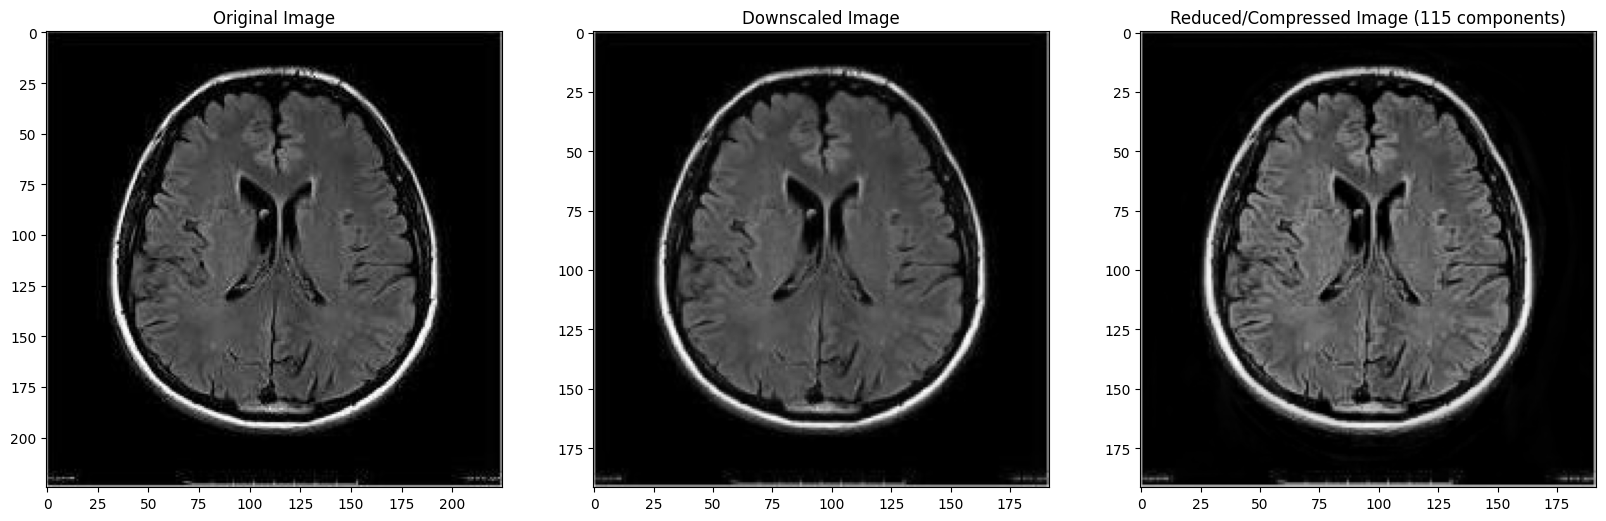

In [143]:
# Pick a random image to compare
# Divided by 4 compared to random_state to find a good template image
random.seed(a=36864/4)
image_num = random.randint(0, len(cancer_images))

linear_imgs = linear_pca.inverse_transform(linear_pca_results)
lin_components = num_components

fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(cancer_images[image_num], cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(images[image_num].reshape(192, 192), cmap='gray')
ax[1].set_title("Downscaled Image")
ax[2].imshow(np.clip(linear_imgs[image_num].reshape(192,192), 0, 1), cmap="gray")
ax[2].set_title("Reduced/Compressed Image (" + str(lin_components) + " components)")
plt.show()

We pick a new index as compared to the one used during data cleaning, to hopefully give us a better sense of what's happening to any given image, and also disassociate the data cleaning process with the data reduction process (which are both components of the wider umbrella of preprocessing). Just like the randomization of PCA we will cover in a moment, the randomly selected image is controlled by a set value to keep the cells verifiable

As we can see from the image, we appear to retain a great deal of information compared to the downscaled image, which is what we were hoping for. We will need to take a more thorough look at the statistical difference between these images later, but we can at least verify that the PCA is performing as expected and is able to accurately compute a method for seperating the image into highly (at least visually) repersenatative components of the original image.

In fact, in some areas (such as around the edges of the brain), it appears we may even have slightly more definition/sharpness as compared to the compressed image, which might help make features like brain tumors easier to discern - this remains merely speculation without further analysis, but it is interesting to see how the anti-alising and PCA have resulted in an image with less artifacting & blurring (the boxes of pixels visable in the original image) than the original, despite being smaller and containing less data & information.

### 3.3 Randomized PCA
Next we can repeat the same process as before, except with a randomized PCA instead of a linear one. By comparison, with the randomized PCA we might expect worse results but a much shorter time to compute the transformation, although perhaps with this dataset it may prove to be more valuable than the linear PCA and its full SVD solver given the number of features. There's more nuance to the differences between the methods, but this will be saved for after the transformation is complete and we have results to elaborate against.

Again, we'll find our component threshold and then take a "final" PCA using that amount to get the transformation that we need to visualize the newly reduced images. One notworthy aspect present in the code is that the random_state parameter (mentioned earlier) has been passed with a largely arbitrary argument of 36864 (the number of pixels in an image) so that the results in this notebook are verifiable: feel free to experiment with different values or remove the value entirely if you want to examine randomized PCA more fully on your own.

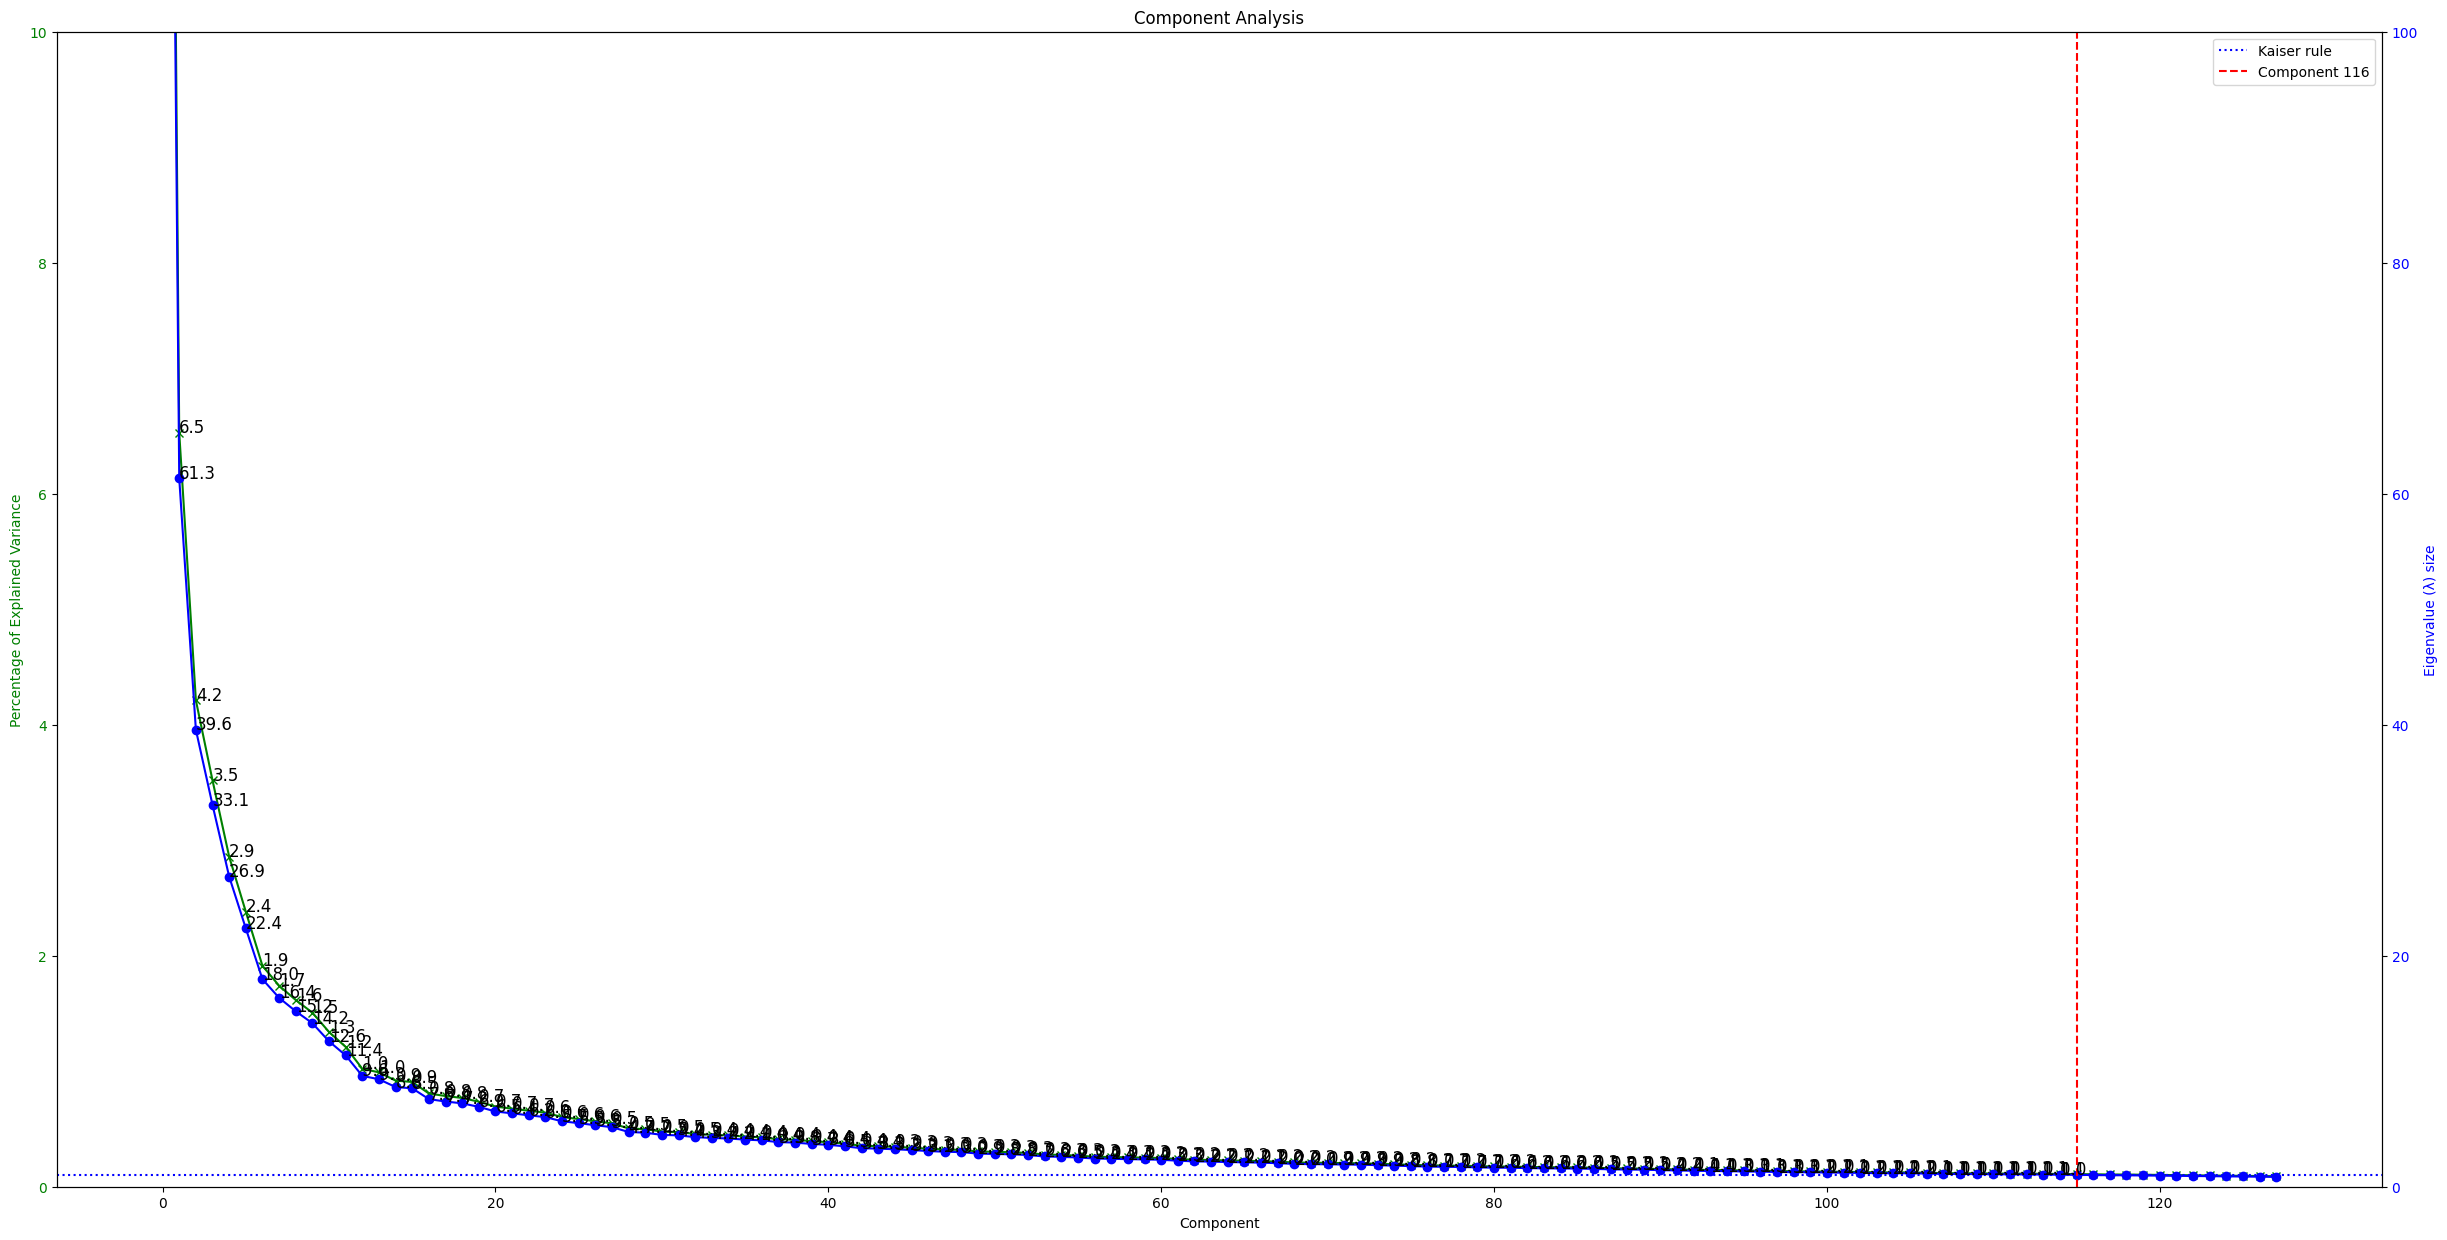

Amount of variance explained by 115 components s.t. λ_component > 1: 84.69999999999999%


In [125]:
# Randomized PCA
# Set random_state arbitrarily to pixel count to keep results repeatable
pca = PCA(n_components=128, svd_solver="randomized", random_state=36864)
pca_results = pca.fit_transform(images)

color_var = "#008000"
color_eig = "#0000FF"
cutoff = 1
ylim = 10
fig, ax_var = plt.subplots(figsize=(30,15))
ax_eig = ax_var.twinx()
ax_var.set_xlabel("Component")
ax_var.set_title("Component Analysis")
ax_var.set_ylim(0, ylim)
ax_eig.set_ylim(0, ylim * 10)

ax_var.plot(pca.explained_variance_ratio_ * 100, marker="x", color=color_var)
ax_var.set_ylabel('Percentage of Explained Variance', color=color_var)
ax_var.tick_params(axis="y", labelcolor=color_var)

ax_eig.plot(pca.explained_variance_, marker="o", color=color_eig)
ax_eig.set_ylabel("Eigenvalue (λ) size", color=color_eig)
ax_eig.tick_params(axis="y", labelcolor=color_eig)
ax_eig.axhline(y=cutoff, linestyle=":", label="Kaiser rule", color=color_eig)

intersection = np.argwhere(np.diff(np.sign(cutoff - pca.explained_variance_))).flatten()
if len(intersection) == 0:
    num_components = len(pca.explained_variance_)
else:
    num_components = intersection[0] - 1
    ax_eig.axvline(x=num_components, linestyle="dashed", label="Component %d" %(num_components + 1), color="red")

randomized_pca = PCA(n_components=num_components, svd_solver="full")
randomized_pca_results = randomized_pca.fit_transform(images)

sum = 0
for index in range(num_components):
    if(len(intersection) > 0):
        sum = sum + (pca.explained_variance_ratio_[index] * 100).round(1)
    if pca.explained_variance_ratio_[index] * 100 <= ylim:
        ax_var.text(index, pca.explained_variance_ratio_[index] * 100, (pca.explained_variance_ratio_[index] * 100).round(1), size=12)
    if pca.explained_variance_[index] <= ylim * 10:
        ax_eig.text(index, pca.explained_variance_[index], pca.explained_variance_[index].round(1), size=12)
    
ax_eig.legend(loc="upper right")
plt.show()
print("Amount of variance explained by " + str(num_components) + " components s.t. λ_component > 1: " + str(sum) + "%")

Immediately we see our first visual/notable difference between the two methods: where the linear PCA fitting required 116 components to explain ~85% of the image's varience, the randomized PCA only needed 115. This is not a huge difference (<1%) in components, but still noteworthy in the sense that you would not generally expect randomized methods to need fewer components to explain the same amount of varience. Otherwise, the graphs appear to follow the same general trend (which is good, as that means randomized PCA is finding similiar components as compared to linear PCA).

Since randomized PCA looks at the number of principal components instead of the number of features as its asympotoic bounding term, this process (although not timed) was significantly faster than the linear PCA. Given that this means it uses a random projection matrix instead of computing the eigenvectors of a covarience matrix in order to achieve this speedup, we generally expect worse performance. However, the randomized PCA appears to have a good job explaining the varience of the images, so we can proceed to visually displaying one of the iamges and checking to see if there's any noteworthy interactions happening between it and the downscaled & original images.

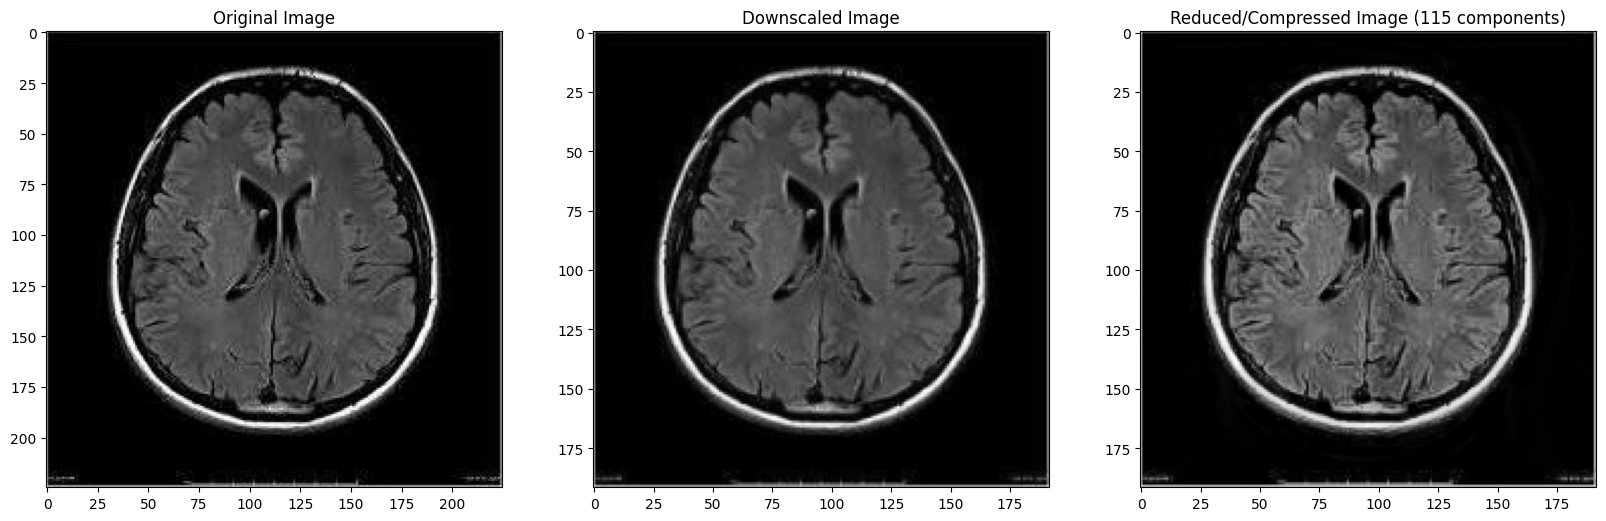

In [144]:
randomized_imgs = randomized_pca.inverse_transform(randomized_pca_results)
rand_components = num_components

fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(cancer_images[image_num], cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(images[image_num].reshape(192, 192), cmap='gray')
ax[1].set_title("Downscaled Image")
ax[2].imshow(np.clip(randomized_imgs[image_num].reshape(192,192), 0, 1), cmap="gray")
ax[2].set_title("Reduced/Compressed Image (" + str(rand_components) + " components)")
plt.show()

Visually, at least, we appear to see the same performance that we saw with the linear PCA, which makes sense as the amount of varience explained by both was essentially the same. Again, the sharpness of the image appears to be higher as compared with the downscaled image, although the overall amount of noise has decreased, and the result overall appears to be promising: while the randomized PCA was very quick it was still able to create a image that - on first glance - looks similiar to the linear PCA result and certainly appears to capture the information contained within the downscaled image without inject too many artifacts or other corruptions of the image.

To determine which would be best suited to the task of classification, however, we will need to dive deeper and begin examining proper statistics to compute a quantifiable measurement of accuracy/error. However, randomized PCA is at least able to resolve the components of the image in a sensible manner which is already a step in the right direction. Onward, then, to the deep dive!

### 3.4 PCA Method Comparison


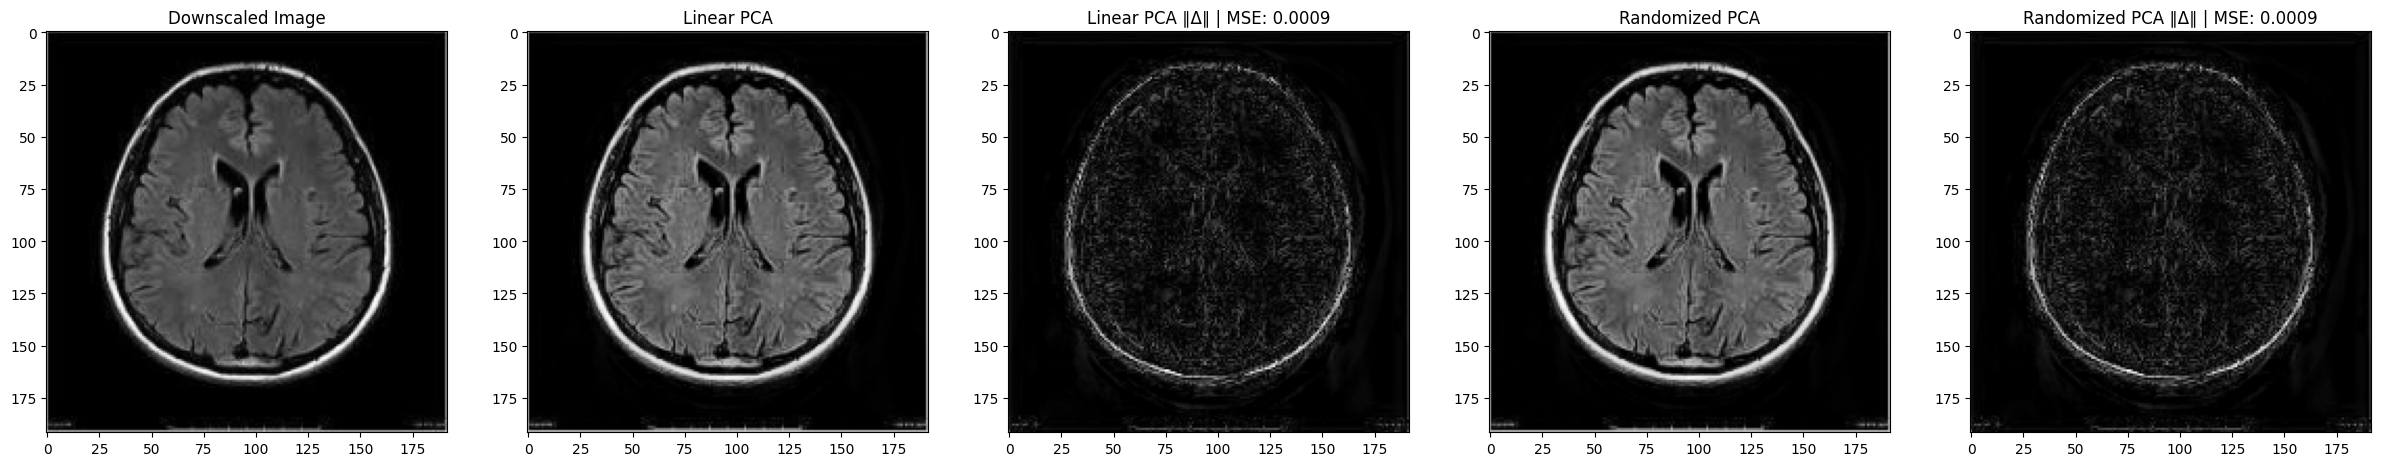

In [145]:
fig, ax = plt.subplots(1, 5, figsize=(30,15))

ax[0].set_title("Downscaled Image")
ax[0].imshow(images[image_num].reshape(192, 192), cmap='gray')

ax[1].set_title("Linear PCA")
ax[1].imshow(np.clip(linear_imgs[image_num].reshape(192,192), 0, 1), cmap="gray")

ax[2].set_title("Linear PCA ∥Δ∥ | MSE: " + str(round(mean_squared_error(images[image_num], np.clip(linear_imgs[image_num], 0, 1)), 4)))
ax[2].imshow(abs(images[image_num] - np.clip(linear_imgs[image_num], 0, 1)).reshape(192,192), cmap="gray")

ax[3].set_title("Randomized PCA")
ax[3].imshow(np.clip(randomized_imgs[image_num].reshape(192,192), 0, 1), cmap="gray")

ax[4].set_title("Randomized PCA ∥Δ∥ | MSE: " + str(round(mean_squared_error(images[image_num], np.clip(randomized_imgs[image_num], 0, 1)), 4)))
ax[4].imshow(abs(images[image_num] - np.clip(randomized_imgs[image_num], 0, 1)).reshape(192,192), cmap="gray")

plt.show()

Now we can begin to take a closer look at the images themselves. More specifically, we can examine a number of different statistics: the L2 norm (∥Δ∥ or sqrt(num**2)) & the mean squared error (MSE or ∑(x - x̂)**2). These will both provide a better idea of whether or not the respective methods were able to - statistically - accurately represent the original downscaled image.

More specifically, the L2 norm will show us the Euclidean distance between the correct (original) pixel color & what was actually obtained between the pixel: the brighter any given pixel in the comparison image, the worse the error is. Ideally this means we have an entirely black image, or at least a white circle (the skull, which we care the least about) that's black inside (meaning the brain matter was accurately visualized).

The MSE, on the other hand, can give us an aggregated (uniform average) amount of lost information between the two images, with 0 being a perfect score and 1 having absolutely no information from the ground truth image (the downscaled image, in this case). In many ways, this can be thought of being a near-analog to an average of L2 norm error (the L2 norm representing the least absolute error rather than the least squared error), although it remains more sensitive to outliers within the data, which might be valuable for identifying if we have a significant number of artifacts within the image.

And as the result of the above graphs show, we appear to have a very close tie: both methods result in a difference image that, while containing a fair amount of noise, appears to look identical when compared to each other, and both have the same approximate MSE of 0.0009, which is very low. The difference image does, however, do a good job of highlighting a degree of banding around the skills, which is a common aspect of artifacting that happens from this form of dimensionality reduction. That notwithstanding, though, the results continue to show a high degree of accuracy that we can now proceed with quantifying & evaluating with respect to the comparison between both forms of PCA themselves (rather than exclusively against the reference image).

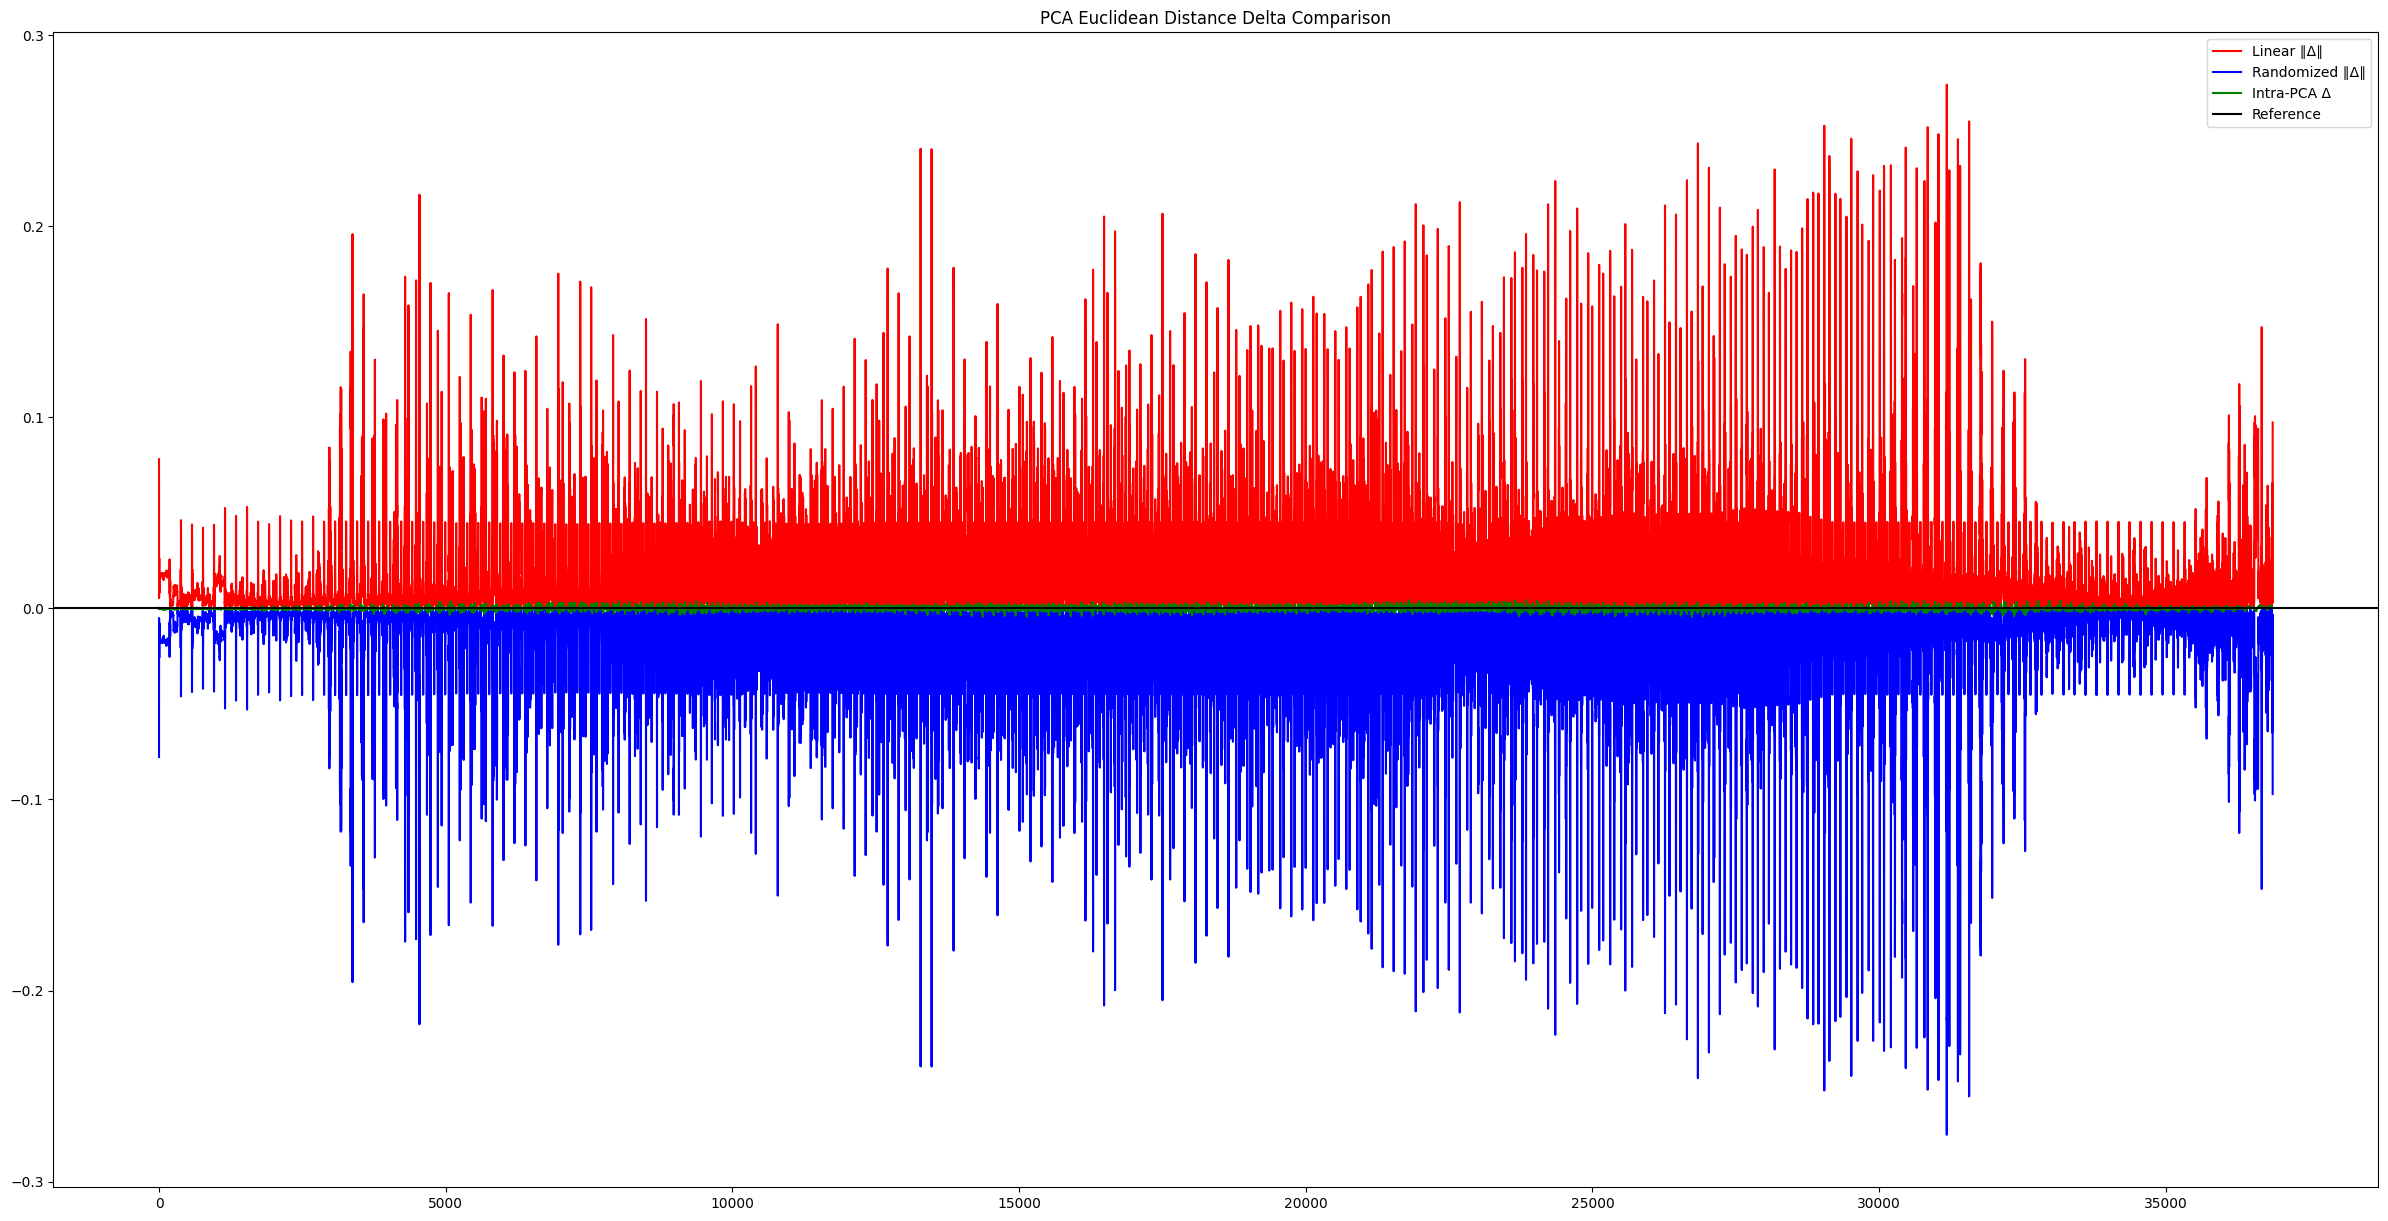

The linear PCA had a similarity of 92.81%
The randomized PCA had a similarity of 92.87%
-------------------------------------------------
The randomized PCA was more accurate by 0.06%
And used 0 additional components by comparison.


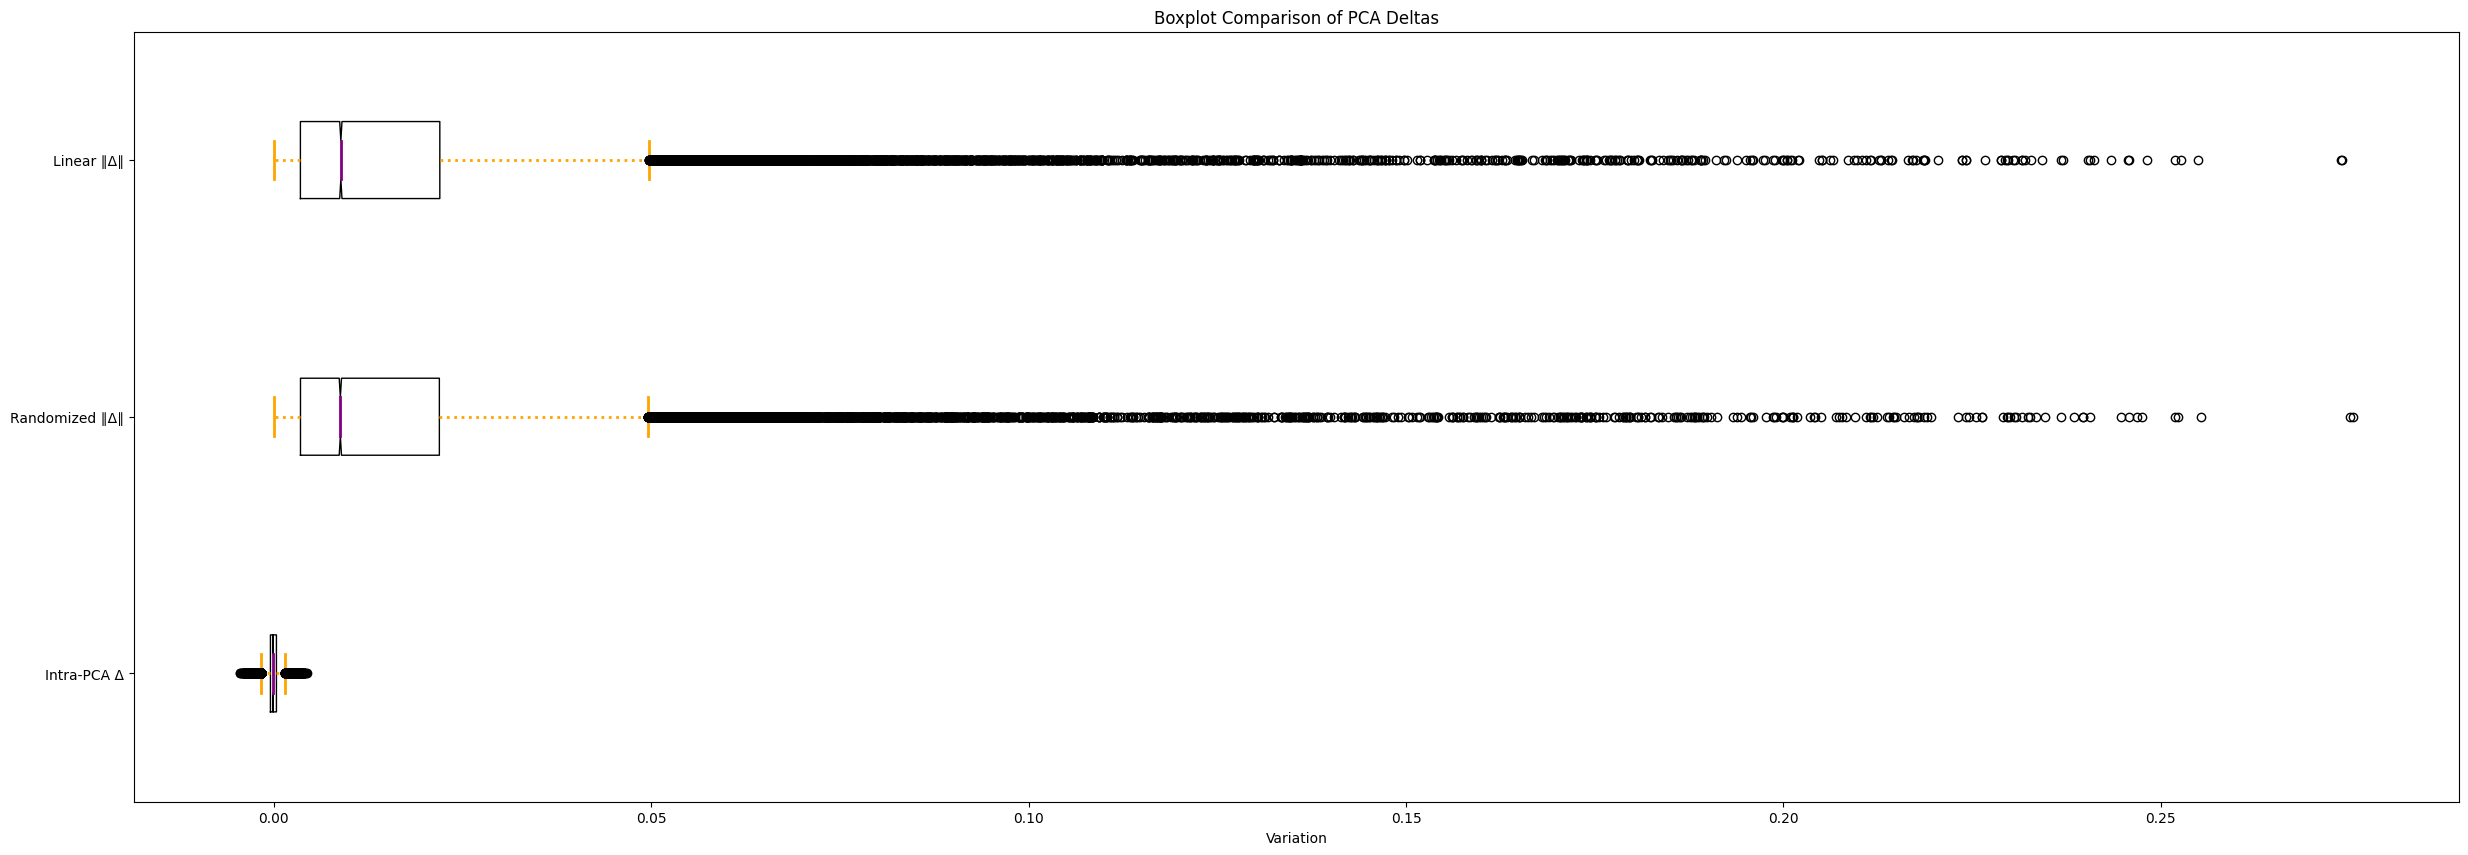

In [146]:
plt.figure(figsize=(30, 15))
plt.title("PCA Euclidean Distance Delta Comparison")

plt.plot(np.abs(linear_imgs[image_num]-images[image_num]), color="red", linestyle="-", label="Linear ∥Δ∥")
plt.plot(-np.abs(randomized_imgs[image_num]-images[image_num]), color="blue", linestyle="-", label="Randomized ∥Δ∥")
plt.plot(randomized_imgs[image_num]-linear_imgs[image_num], color="green", linestyle="-", label="Intra-PCA Δ")
plt.axhline(y=0, color="black", linestyle="-", label="Reference")
plt.legend(loc="upper right")
plt.show()

lin_score, _ = ssim(linear_imgs[image_num], images[image_num], full=True)
rand_score, _ = ssim(randomized_imgs[image_num], images[image_num], full=True)
print("The linear PCA had a similarity of " + str(round(lin_score * 100, 2)) + "%")
print("The randomized PCA had a similarity of " + str(round(rand_score * 100, 2)) + "%")
print("-------------------------------------------------")
# Agony. Anguish. Despair.
print("The "
      + ("linear" if lin_score >= rand_score else "randomized")
      + " PCA was more accurate by "
      + str(round(max(lin_score - rand_score, rand_score - lin_score) * 100, 2))
      + "%\nAnd used "
      + str(abs(lin_components - rand_components))
      + (" additional" if lin_score >= rand_score and lin_components - rand_components >= 0 or rand_score >= lin_score and rand_components - lin_components >= 0 else " fewer")
      + " components by comparison.")

# Add a box & whisker plot to view the distribution of the amount of error for each
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111)
boxplots = ax.boxplot([randomized_imgs[image_num]-linear_imgs[image_num], np.abs(randomized_imgs[image_num]-images[image_num]), np.abs(linear_imgs[image_num]-images[image_num])], notch=True, vert=False)
ax.set_yticklabels(["Intra-PCA Δ", "Randomized ∥Δ∥", "Linear ∥Δ∥"])
for median in boxplots["medians"]:
    median.set(color="purple", linewidth=2)
for whisker in boxplots["whiskers"]:
    whisker.set(color="orange",linewidth=2, linestyle=":")
for cap in boxplots["caps"]:
    cap.set(color="orange", linewidth=2)
plt.title("Boxplot Comparison of PCA Deltas")
plt.xlabel("Variation")
plt.show()

Finally, we come to a more direct comparison between the two methods, looking at a graphing of their ∥Δ∥s and then comparing each against each other to compute a difference (delta/Δ) between them. But before diving into the meaning the graphs, we must first understand the intuition between them.

To begin with, the first graph is much like the image difference graphs from before, except this time mapped 1:1 with each pixel and having the amount of error graphs as a value rather than as a color, which allows us to view the overall distribution of error and more easily determine the magnitude of any given error with the PCA methods. Note that while the randomized PCA ∥Δ∥ is listed as being negative, this is simply inverted for the purposes of visualization and represents a positive number (as negative error would make no sense).

From this graph we can directly compute the similarity of each image to the original and provide a percentage score of the absolute similarity, from which we can see both images achieving >90% accuracy in depicting the image. Although the MSE was the same for both, however, we are able to determine that the randomized PCA, despite explaining slightly less of the image is actually slightly closer to it than the linear PCA, while taking far less time & one less component.

Of course, before we determine a "winner" between the methods, we can also look at each point of error within a more classical graph for distribution analysis: the venerable boxplot. This final graph provides us with an insight into the amount of error and where it centralizes around, that being approximately ~0.01 for both methods, with the randomized PCA having somewhat more spread in the amount of error (variation) in its outliers. Finally, we can compare the methods against themselves, which shows that they have almost no difference with a tiny IQR and median of ~0.0, meaning that on average neither of them significantly deviated from the other in terms of what a pixel's color/brightness was supposed to be.

Overall, then, we can conclude that both methods are able to accurate (>90%) compress & represent the original data within any given brain scan image, with randomized PCA being so closely tied to the linear PCA that using it for its extreme performance differences is absolutely worthwhile, at least within the context of this dataset. As always, we do not speak in absolutes as every dataset is different and the various methods/kernels of PCA are simply tools to be applied to them, and with this comes the inevitable reality that sometimes certain methods will perform significantly differently from each other, even if this was not the case in this dataset.

### 3.5 DAISY

Let's apply DAISY to see the results of reducing the feature set. 

DAISY may prove better results than PCA or RPCA because DAISY preserves spatial information after processing, so we can assume that it'll be more promising for our image data. PCA and RPCA remove that spatial information and treat the image as if its just some numerical data without any other context around it. DAISY captures relevant angular information of an image and their magnitude, and is also able to calculate the number of angles within a certain area and what the distribution of each of those angles within that area.

Daisy comes with several hyperparamters that we can tune to our favourite flavor, 
It works choosing a central point in the image, and forming an initial ring around that central point and calculates histograms with a defined radius size around that ring. The rings paramter defines how many rings are created for histogram calculation and concatenation. DAISY allows you to define the number of "orientations" which are sectors of angular direction to which build into histogram calculation. Each orientation is a "bin" or "sector" or a set of angles and their respective magnitudes. 

In [17]:
# DELETE BELOW BEFORE SUBMITTING AND UNCOMMENT CODE UNDERNEATH
original_shape = (192, 192)
images_2 = np.array([ image.reshape(original_shape) for image in images ][:20])
y = df['class'][:20]
randomized_pca_results_2 = randomized_pca_results[:20, :]

# original_shape = (192, 192)
# images_2 = [ image.reshape(original_shape) for image in images ] # uncomment this and remove above when we're ready to unleash the beast
# y = df['class']
# randomized_pca_results_2 = randomized_pca_results[:, :]


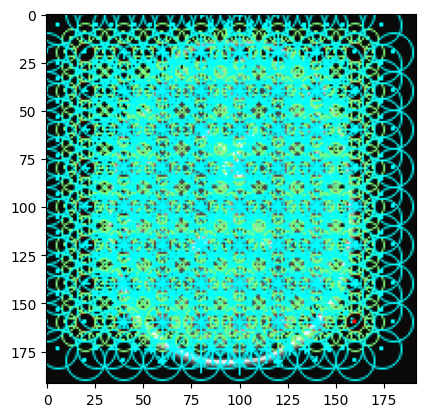

In [18]:
from skimage.color import rgb2gray, gray2rgb
from skimage.feature import daisy
import random
import matplotlib.pyplot as plt

def apply_daisy(row, step, radius, rings, histograms, orientations):
        print(row.shape)
        feat = daisy(row, step=step, radius=radius, 
            rings=rings, histograms=histograms, orientations=orientations, 
            visualize=False)
        return feat.reshape(-1)

    
# original_shape = (3*192, 192) #(576, 192)
shape = original_shape
rand_idx = random.randint(0, len(images_2)-1)


features, img_desc = daisy(images_2[rand_idx], 
                           step=20, 
                           radius=20, 
                           rings=2, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
plt.imshow(img_desc)
plt.grid(False)

We can see a strong mass of the descriptors where the Brain is located towards the center of the image. This is good as this means we're able to detect curvatures, lines, and other spatial features.

In [19]:
daisy_feature_imgs = np.array(
    [ daisy(row, step=20, radius=20, rings=2, histograms=8, orientations=8, visualize=False) for row in images_2 ])

print("====================")
print(f"Original shape: {images_2.shape}")
print(f"Original number of features: {images_2.shape[0] * images_2.shape[1] * images_2.shape[2]}")

print(f"Post Daisy shape: {daisy_feature_imgs.shape}")
print(f"Post-Daisy number of features: {daisy_feature_imgs.shape[0] * daisy_feature_imgs.shape[1] }")

Original shape: (20, 192, 192)
Original number of features: 737280
Post Daisy shape: (20, 8, 8, 136)
Post-Daisy number of features: 160


Let's see what happens when we increase the amount of rings and histograms, and how that affects the amount of features detected by DAISY. By increasing the radius, we are making the area of each of the circles to compute the histograms of gradients and orientations larger, and the amount of rings means that a higher frequency of histograms will be calculated. I believe this should increase the amount of features detected than previously.

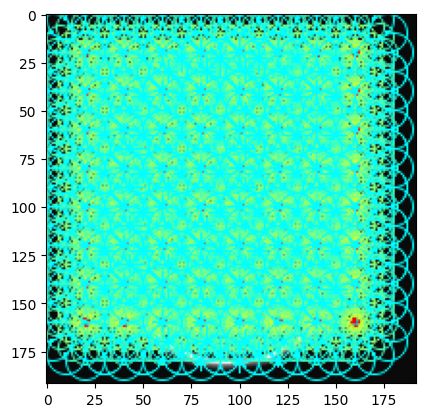

In [20]:
import matplotlib.pyplot as plt

features, img_desc = daisy(images_2[rand_idx].reshape(original_shape), 
                           step=20, 
                           radius=20, 
                           rings=4, 
                           histograms=12, 
                           orientations=8, 
                           visualize=True)
plt.imshow(img_desc)
plt.grid(False)

In [21]:
daisy_feature_imgs = np.array(
    [ daisy(row, step=20, radius=20, rings=4, histograms=12, orientations=8, visualize=False) for row in images_2 ])

print("====================")
print(f"Original shape: {images_2.shape}")
print(f"Original number of features: {images_2.shape[0] * images_2.shape[1] * images_2.shape[2]}")

print("====================")
print(f"Post Daisy shape: {daisy_feature_imgs.shape}")
print(f"Post-Daisy number of features: {daisy_feature_imgs.shape[0] * daisy_feature_imgs.shape[1] }")

Original shape: (20, 192, 192)
Original number of features: 737280
Post Daisy shape: (20, 8, 8, 392)
Post-Daisy number of features: 160


As we expected, there are a larger amount of features detected than before. This tells us that the frequency of features detected per image increases as the number of histograms and radius size increase.


Let's now see what happens when we decrease the step-count, and decrease the number of orientations. The step count represents the spacing between each of the circles centers along each radius to calculate histograms. Step count is an important parameter to understand because it is significant factor in determining the density of local descriptors   and, therefore, the granularity of the feature set. If the step-count is smaller, that means that we can expect a higher granularity in our feature set as each of the circles draw will be closer together. Therefore, that would mean a higher amount of potential local descriptors identified. Because of the increased granularity however, there can be a significant computation cost in decreasing step-count -- insuch cases, increasing it may make sense.


The orientations represent the amount of "bins" of angles being calculated. The number of orientations is used to calculate a gradient of image intensity per each of the circles drawn. A larger number of orientations captures more detailed information about the local texture and structure, but also leads to a higher number of features and a higher compute cost.

I believe that a lower amount of orientations and higher step count will lead to less granularity in our number of features detected; meaning that we should have less features detected. I believe this because if the spacing between each of the centers of the drawn circles are larger, and there is a lesser amount of information about the local angular magnitude of the image; we can expect a coarser-grained feature set with less features. 

Let's see if this is true.

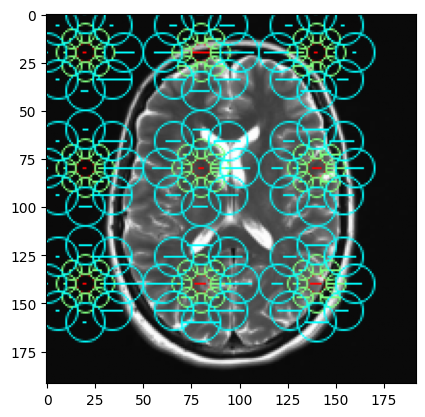

In [22]:
features, img_desc = daisy(images_2[rand_idx].reshape(original_shape), 
                           step=60, 
                           radius=20, 
                           rings=2, 
                           histograms=8, 
                           orientations=2, 
                           visualize=True)
plt.imshow(img_desc)
plt.grid(False)

In [23]:
daisy_feature_imgs = np.array(
    [ daisy(row, step=20, radius=20, rings=2, histograms=8, orientations=8, visualize=False).flatten() for row in images_2 ])

print("====================")
print(f"Original shape: {images_2.shape}")
print(f"Original number of features: {images_2.shape[0] * images_2.shape[1] * images_2.shape[2]}")

print("====================")
print(f"Post Daisy shape: {daisy_feature_imgs.shape}")
print(f"Post-Daisy number of features: {daisy_feature_imgs.shape[0] * daisy_feature_imgs.shape[1] }")

Original shape: (20, 192, 192)
Original number of features: 737280
Post Daisy shape: (20, 8704)
Post-Daisy number of features: 174080


Yep, seems like we were right! The amount of features drastically reduced. Lets now take the pairwise distances of both the random PCA and DAISY and fit them to a heatmap so we can see a visual

In [28]:
from sklearn.metrics.pairwise import pairwise_distances
daisy_pairwise = pairwise_distances(daisy_feature_imgs)

(20, 20)


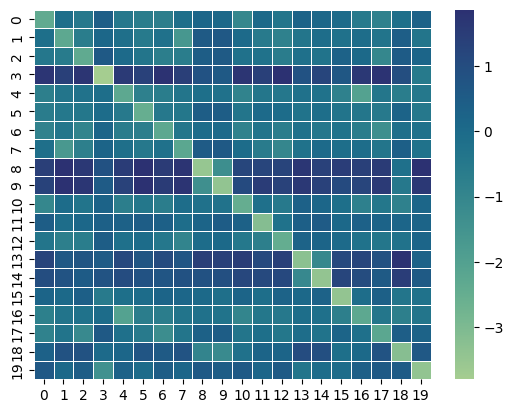

In [29]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_pairwise_daisy_imgs = scaler.fit_transform(X=daisy_pairwise, y=None)
print(scaled_pairwise_daisy_imgs.shape)
sns.heatmap(scaled_pairwise_daisy_imgs, linewidth=.5, cmap="crest")
plt.show()

From this heatmap of pairwise distances generated from DAISY, we can see the resultant similarities of each of the images and their respective p, q, and r values. We can see the those values are brightest along the diagnol, as the diagnol is a mapping of each image on either axis to its respective image representation on the other axis. The values on the heat map range from just under -3 to a little over +1. The small difference in between the minimum and maximum in the range indicates most of the images are quite similar to one another. However, one can see that images 3, 8 and 9 on the horizontal axis are quite dissimilar to any of the other images indicated by their larger pairwise distance values. 

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

knn_pca = KNeighborsClassifier(n_neighbors=1)
knn_dsy = KNeighborsClassifier(n_neighbors=1)

rpca_train, rpca_test, dsy_train, dsy_test, y_train, y_test = train_test_split(
    randomized_pca_results_2,daisy_feature_imgs, y, test_size=0.2, train_size=0.8)

knn_pca.fit(rpca_train,y_train)
acc_pca = accuracy_score(knn_pca.predict(rpca_test),y_test)

knn_dsy.fit(dsy_train,y_train)
acc_dsy = accuracy_score(knn_dsy.predict(dsy_test),y_test)

print(f"PCA accuracy:{100*acc_pca:.2f}%, Daisy Accuracy:{100*acc_dsy:.2f}%".format())

PCA accuracy:100.00%, Daisy Accuracy:100.00%


As we can see the KNN Classifier on the DAISY data ran more accurately than that of the KNN on the PCA data. This is because we are using image data, and the DAISY feature descriptors retain spatial information about each of the individual pixels versus PCA applies indiscriminate reduction of the feature set. 

Lets now attempt to run the Gabor Filters on our data and see if any more spatial information is preserved, and see the feature reduction output:

First, let's explore some of the hyper parameters and define them

Frequency - the rate of change of in amplitude for the sinusoidal wave in a gabor filter, a higher frequency means that the filter will be able to capture more finer details in the input image

Theta - This determines the orientation of our filter, which kinds of lines or angles our filter will be sensitive to picking up

Sigma_x - This controls the horizontal size of the filter, the larger this number is the more coarse variations in horizontal textures the filter can pick up

Sigma_y - Controls the vertical size of the filter, a larger value will allow the filter to capture more coarser textures in the vertical direction

Let's look at the filters alone before analyzing applied on our input images.

We'll use a sigma of 2, theta of pi/4, and frequency of .25 to start with

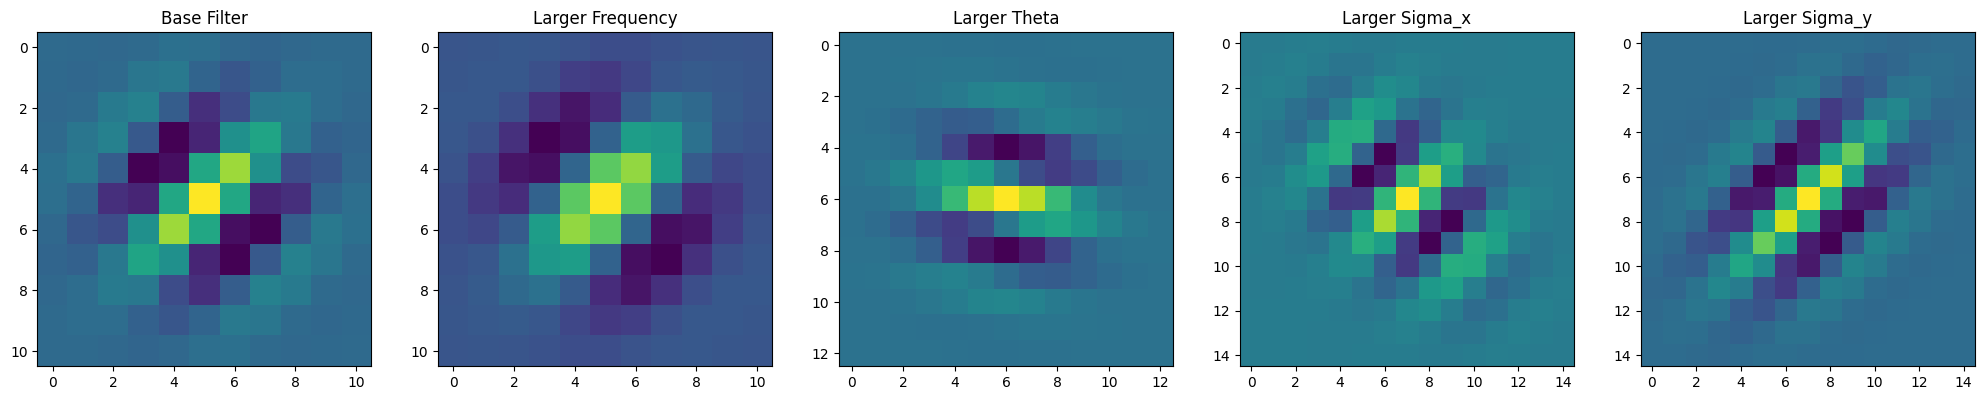

In [51]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats
import matplotlib.pyplot as plt

# Base values
sigma = 2
theta = 1 * np.pi/4
frequency = .25

kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
kernel2 = np.real(gabor_kernel(frequency+1, theta=theta, sigma_x=sigma, sigma_y=sigma))
kernel3 = np.real(gabor_kernel(frequency, theta=theta+1, sigma_x=sigma, sigma_y=sigma))
kernel4 = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma+1, sigma_y=sigma))
kernel5 = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma+1))

# plt.imshow(kernel)
fig, ax = plt.subplots(1, 5, figsize=(25,10))
ax[0].imshow(kernel)
ax[0].set_title("Base Filter")
ax[1].imshow(kernel2)
ax[1].set_title("Larger Frequency")
ax[2].imshow(kernel3)
ax[2].set_title("Larger Theta")
ax[3].imshow(kernel4)
ax[3].set_title("Larger Sigma_x")
ax[4].imshow(kernel5)
ax[4].set_title("Larger Sigma_y")
plt.show()


In the above we can see the different outputs for variations in each of the hyper parameters. We can see that the larger frequency kernel has a larger intensity in terms of size, and the larger sigma_x and larger sigma_y plots both have intensities in either the horizontal and vertical directions respective to their axes. The larger Theta kernel has a different orientation as expected as well.

First we'll define our filter banks, and build our kernels to compute the Gabor Filter convolution. Then we'll specify additional hyper parameter values compute the gabor filters, and aggregate the statistical data given from each convolution to process them later for classification.

In [52]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

kernels = []
sigma_vals = (1, 3, 5)
frequencies = (0.05, 0.15, 0.25, 0.35)

for theta in range(num_orientations):
    theta = theta / 8. * np.pi
    for sigma in sigma_vals:
        for frequency in frequencies: 
            kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

In [53]:
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
    return feats.reshape(-1)

gabr_feature = compute_gabor(images_2[rand_idx], kernels, original_shape)
gabr_feature.shape

(384,)

In [60]:
gabor_res = np.array([ compute_gabor(row, kernels, original_shape) for row in images_2 ])
knn_gab = KNeighborsClassifier(n_neighbors=1)

gab_train, gab_test, y_train, y_test = train_test_split(
    gabor_res,y,test_size=0.2, train_size=0.8)
knn_gab.fit(gab_train,y_train)
acc_gab = accuracy_score(knn_gab.predict(gab_test),y_test)

print(f"Gabor shape: {gabor_res.shape}")
print(f"PCA accuracy:{100*acc_pca:.2f}%")
print(f"Daisy accuracy:{100*acc_dsy:.2f}%".format())
print(f"Gabor accuracy is: {100*acc_gab:.2f}%")
print(f"")

Gabor shape: (20, 384)
PCA accuracy:100.00%
Daisy accuracy:100.00%
Gabor accuracy is: 100.00%



As we can see, the Gabor filters outperform the PCA, and DAISY algorithms in terms of classification. It also highly reduces the initial feature set. This is likely because of the highly tuneable hyper parameters which allow our kernel to be sensitive to many different spatial variations, as well as intensities of the image. It is clear that Gabor Filters are highly important in classifying Cancerous Brains vs those that aren't.